### GMM but multi-dimensional
with theo's help, close to running

Notes: 
I shouldn't use numpyro.param unless I am making my own guide, and I am 

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from matplotlib import pyplot
%matplotlib inline

import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer.autoguide import AutoDelta
from numpyro.infer import SVI, Trace_ELBO

In [2]:
df = pd.read_csv('/Users/victorlhoste/Desktop/Local_PhD/NHANES/Data/data_pyro.csv', index_col=0)
df.head()

,height,bmi,WHtR,hba1c,hdl,non_hdl,sbp,dbp,eGFR,age_group
1,178.8,25.524376,0.496644,5.3,0.9842,5.9570,117,59,95.625163,Young
2,162.2,23.433188,0.557953,4.6,1.4245,2.7195,130,88,114.670330,Young
3,156.9,27.642813,0.570427,5.3,1.7094,4.4030,134,75,87.324169,Middage
4,177.4,29.392363,0.576099,4.6,1.1137,4.7138,135,94,77.957926,Young
5,168.2,24.954721,0.558859,9.1,1.3209,5.4131,121,69,79.104629,Middage


In [3]:
df = df[["height","bmi","WHtR","hba1c","hdl","non_hdl","sbp","dbp","eGFR"]]
d=9 # dimension
df_centered = df.apply(lambda x: (x - x.mean())/x.std() )
#print(df_centered)
# data=torch.tensor(df_centered.values)
data=df_centered
data.shape

(58876, 9)

In [4]:
# data.mean(axis=0)
key = jax.random.PRNGKey(1) ### needed for Jax otherwise it doesn't run
dist.MultivariateNormal(
    jnp.zeros(9),
    (0.5*jnp.eye(9))
).sample(key, (1,))

DeviceArray([[ 0.4884729 , -0.34467286, -0.8172662 ,  0.08561976,
               0.8492481 , -0.35912296,  0.6474882 ,  1.2089263 ,
              -0.25985762]], dtype=float32)

In [5]:
data

,height,bmi,WHtR,hba1c,hdl,non_hdl,sbp,dbp,eGFR
1,1.168186,-0.456668,-0.925723,-0.336735,-0.915115,1.936171,-0.392283,-1.058891,0.186490
2,-0.483296,-0.783355,-0.279489,-0.986232,0.150982,-0.940821,0.275890,1.343212,0.960026
3,-1.010577,-0.125724,-0.148007,-0.336735,0.840810,0.555215,0.481481,0.266407,-0.150661
4,1.028905,0.147592,-0.088218,-0.986232,-0.601557,0.831406,0.532879,1.840198,-0.531079
5,0.113625,-0.545659,-0.269946,3.189105,-0.099864,1.452837,-0.186692,-0.230580,-0.484505
...,...,...,...,...,...,...,...,...,...
121359,1.297519,-0.740389,-1.156648,0.034406,1.279791,-0.411455,-0.083896,0.597732,0.077173
121362,-1.050372,-1.318701,-0.624310,1.611755,0.464540,-1.999555,0.841267,0.100745,-0.130726
121363,-0.214682,1.151621,1.177504,0.219977,-0.225287,-0.296375,-0.289487,0.266407,0.459758
121364,-0.443502,-0.361139,-0.559742,-0.429520,0.088271,-0.641614,-0.443681,0.100745,1.394330


In [6]:
np.asarray(data)

array([[ 1.16818633, -0.45666756, -0.92572325, ..., -0.39228322,
        -1.05889073,  0.18649042],
       [-0.48329643, -0.78335454, -0.27948912, ...,  0.27588975,
         1.34321152,  0.96002567],
       [-1.01057707, -0.12572355, -0.14800652, ...,  0.48148143,
         0.26640706, -0.15066133],
       ...,
       [-0.21468176,  1.15162078,  1.17750434, ..., -0.28948738,
         0.26640706,  0.45975806],
       [-0.44350166, -0.36113942, -0.55974171, ..., -0.44368114,
         0.10074484,  1.39432987],
       [ 0.86972559,  1.19195885,  1.15421921, ...,  1.1496544 ,
         1.9230293 ,  0.86075981]])

In [7]:
## Multivaiate model
# I think I have some issues with the priors

 # Fixed number of components.

def model(K,h,data=None):
    # Global variables.
    weights = numpyro.sample('weights', dist.Dirichlet(0.5 * jnp.ones(K)))
    scale = numpyro.sample('scale', dist.HalfNormal(2.)) # same variance paramter for all clusters
    with numpyro.plate('components', K):
        locs=numpyro.sample('locs',dist.MultivariateNormal(jnp.zeros(h),jnp.eye(h))) #  weird

    with numpyro.plate('data', len(data)):
        # Local variables
        assignment = numpyro.sample('assignment', dist.Categorical(weights))
        numpyro.sample('obs', dist.MultivariateNormal(locs[assignment], scale*jnp.eye(h)), obs=data)



In [8]:
key = jax.random.PRNGKey(3)
h=9
locs=dist.MultivariateNormal(jnp.zeros(h),jnp.eye(h)).expand([2]).sample(key)
dist.MultivariateNormal(locs[1], 0.5*jnp.eye(h)).sample(key)


DeviceArray([ 1.5053518 ,  0.48227185, -0.984928  , -0.25600165,
              0.43856192, -1.2653244 , -1.2724206 ,  1.7150483 ,
              0.0498327 ], dtype=float32)

In [9]:
### This is running the model without any data just to make sure that the shape of the different objects are correct
# there is no fitting here


with numpyro.handlers.seed(rng_seed=1):
    trace = numpyro.handlers.trace(model).get_trace(data=np.asarray(data),K=3,h=9)
print(numpyro.util.format_shapes(trace))

   Trace Shapes:          
    Param Sites:          
   Sample Sites:          
    weights dist       | 3
           value       | 3
      scale dist       |  
           value       |  
components plate     3 |  
       locs dist     3 | 9
           value     3 | 9
      data plate 58876 |  
 assignment dist 58876 |  
           value 58876 |  
        obs dist 58876 | 9
           value 58876 | 9


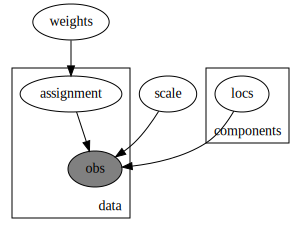

In [10]:
numpyro.render_model(model, model_args=(3,9,np.asarray(data)))

In [11]:
#guide = AutoDiagonalNormal(model) # The guide is what is doing the variational inference instead of the MCMC, basically fitting a distribution on the param to estimate (I think)
#optimizer = numpyro.optim.Adam(step_size=0.001) # Step size is the learning rate, you want to start low and increase
#svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [12]:
# I changed it to this 
# Previously it was what is in the cell above

# Gives the error : 'AutoDiagonalNormal' object has no attribute '_init_latent'
global_guide = AutoDelta(model)
optimizer = numpyro.optim.Adam(step_size=0.001) # Step size is the learning rate, you want to start low and increase
svi = SVI(model, global_guide, optimizer, loss=Trace_ELBO())

In [13]:
rng_key = jax.random.PRNGKey(0) # Specificity of Jax (the tensor flow equivalent I think), you need to set the seed and use it in the line after

svi_result = svi.run(rng_key, 10000,K=5,h=9,data= np.asarray(data))
params = svi_result.params

/var/folders/81/b4cplk1j4x11rl7011b9bpx40000gn/T/ipykernel_9695/3324042575.py:3: FutureWarning: Some algorithms will automatically enumerate the discrete latent site assignment of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  svi_result = svi.run(rng_key, 10000,K=5,h=9,data= np.asarray(data))


ValueError: Continuous inference cannot handle discrete sample site 'assignment'.